In [121]:
# Third-party Library Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon 
from sklearn.neighbors import BallTree
from unidecode import unidecode
from bias_correction import BiasCorrection
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### 1. Read SCM & ERA data

In [182]:
era_final = pd.read_csv("files/ERA/features/era_features_filtered_case11.csv")
era_raw = pd.read_csv("files/ERA/raw/era_basic_preprocessed_filtered_feature_structure_1993_2016.csv").assign(model="ERA", init_month=12)

c3s = pd.read_csv("c3s/data/c3s_hindcasts.csv")
nmme = pd.read_csv("nmme/data/nmme_hindcasts.csv")
apcc = pd.read_csv("clik-apcc/data/apcc_hindcasts.csv")
scm = pd.concat([nmme, c3s, apcc], ignore_index=True).drop_duplicates()
scm = scm.loc[(scm["year"].between(1993, 2016)) & (scm["init_month"].between(9, 11))].reset_index(drop=True)

# Store variables that are used through this notebook
climate_models = [c for c in scm.model.unique().tolist() if c != "ERA"]
crop_seasons = scm["year"].unique().tolist()
relevant_municipalities = list(set([c.split("_")[1] for c in era_final.columns if ("rain" in c) or ("tmean" in c)]))
weather_columns_final = [c for c in era_final.columns if ("rain" in c) or ("tmean" in c)]

weather_columns_raw = []
new_dict = dict(zip(["tmean", "rain"], [dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("tmean" in c)]),
                                        dict.fromkeys([c.split("_")[1] for c in weather_columns_final if ("rain" in c)])]))
for var in new_dict:
    for loc in new_dict[var]:
        new_dict[var][loc] = list(set([int(c.split("_")[-1]) for c in weather_columns_final if (var in c) and (loc in c)]))
        for month in new_dict[var][loc]:
            weather_columns_raw.append("{}_{}_{}".format(var, loc, month))

era_raw = era_raw.loc[:, ["year", "model", "init_month"] + weather_columns_raw]

# Preview
scm.sample(5)

,model,year,init_month,forecasted_month,rain,tmean,lat,lon
244549,METFR,1994,10,11,0.001209,10.948969,-42.0,-68.00
222431,JMA,1993,9,11,0.003333,23.731683,-29.5,-65.25
16957,GFDL,2011,9,10,0.002344,13.368951,-38.0,-56.00
272135,METFR,2014,9,10,0.000377,0.233728,-26.0,-68.00
293846,UKMO,2005,10,11,0.003148,21.054041,-30.0,-67.00


### 2. Filter SCM locations

**2.1 Obtain polygon shapes of relevant municipalities**

To forecast wheat yield in Argentina, we use weather data from two locations - Buenos Aires Coronel Dorrego and Buenos Aires Hipolito Yrigoyen. SCM data is often provided in e.g. 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [183]:
# Read all polygon shapes of Argentinian municipalities
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# Concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# Filter polygon shapes by the relevant municipalities
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_municipalities), ["name", "geometry"]].reset_index(drop=True)
# Convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# Preview
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>}

**2.2 Preview SCM locations and relevant municipality locations with buffer**

<Axes: >

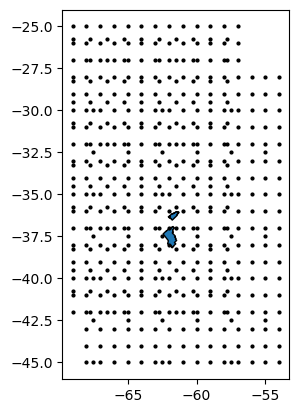

In [184]:
# Convert SCM dataframe to geodataframe to facilitate spatial filtering in the next section
scm = gpd.GeoDataFrame(scm, geometry=gpd.points_from_xy(scm["lon"], scm["lat"]), crs="EPSG:4326")

# Preview SCM locations and municipality polygons
base = gdf_adm2["geometry"].plot(edgecolor="black")
gpd.GeoDataFrame(scm.loc[:, ["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black", markersize=4)

**2.3 Filter SCM hindcasts**

For each relevant municipality, we select K grid cell locations from each SCM that are closest to that municipality. If a SCM has a sparse resolution, it may be that the same grid cell is used for both locations.

In [185]:
def get_nearest_neighbors(src_points, candidate_points, k_neighbors=2):
    '''
    Find k nearest neighbors for all source points from a set of candidate points
    modified from: https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html    

    Parameters
    ----------
    src_points : geopandas.DataFrame
        Geometries to search from.
    candidate_points : geopandas.DataFrame
        Geoemtries to be searched.
    k_neighbors : int, optional
        Number of nearest neighbors. The default is 2.

    Returns
    -------
    gdf_final : geopandas.DataFrame
        gdf1 with distance, index and all other columns from gdf2.
    '''

    src_points = [(x,y) for x,y in zip(src_points.geometry.centroid.x , src_points.geometry.centroid.y)]
    candidates =  [(x,y) for x,y in zip(candidate_points.geometry.x , candidate_points.geometry.y)]

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]
    closest_second = indices[1] # *manually add per comment above*
    closest_second_dist = distances[1] # *manually add per comment above*

    # Return indices and distances
    return (closest, closest_dist, closest_second, closest_second_dist)

In [186]:
filtered_scm = []
for model in climate_models:
    coordinates_of_scm = scm.loc[scm["model"] == model, ["model", "geometry"]].drop_duplicates().reset_index(drop=True).copy()
    (ids_closest, _, ids_second_closest, _) = get_nearest_neighbors(gdf_adm2, coordinates_of_scm, 2)
    filtered_coordinates = coordinates_of_scm.iloc[list(ids_closest) + list(ids_second_closest)].reset_index(drop=True)
    filtered_coordinates = filtered_coordinates.assign(name=pd.Series(2 * relevant_municipalities))
    filtered_scm.append(scm.loc[scm["model"] == model].merge(filtered_coordinates[["name", "geometry"]], on="geometry", how="right"))
    print(filtered_coordinates)
    
filtered_scm = pd.concat(filtered_scm, ignore_index=True)
filtered_scm[["lat", "lon", "name"]].drop_duplicates()

  model                     geometry                            name
0  GFDL  POINT (-62.00000 -38.00000)     buenos aires coronel suarez
1  GFDL  POINT (-62.00000 -36.00000)  buenos aires hipolito yrigoyen
2  GFDL  POINT (-62.00000 -37.00000)     buenos aires coronel suarez
3  GFDL  POINT (-61.00000 -36.00000)  buenos aires hipolito yrigoyen
   model                     geometry                            name
0  CCSM4  POINT (-62.00000 -38.00000)     buenos aires coronel suarez
1  CCSM4  POINT (-62.00000 -36.00000)  buenos aires hipolito yrigoyen
2  CCSM4  POINT (-62.00000 -37.00000)     buenos aires coronel suarez
3  CCSM4  POINT (-61.00000 -36.00000)  buenos aires hipolito yrigoyen
  model                     geometry                            name
0  NASA  POINT (-62.00000 -38.00000)     buenos aires coronel suarez
1  NASA  POINT (-62.00000 -36.00000)  buenos aires hipolito yrigoyen
2  NASA  POINT (-62.00000 -37.00000)     buenos aires coronel suarez
3  NASA  POINT (-61.00000 -36

,lat,lon,name
0,-38.00,-62.0,buenos aires coronel suarez
144,-36.00,-62.0,buenos aires hipolito yrigoyen
288,-37.00,-62.0,buenos aires coronel suarez
432,-36.00,-61.0,buenos aires hipolito yrigoyen
4032,-37.00,-61.5,buenos aires coronel suarez
4176,-35.75,-61.5,buenos aires hipolito yrigoyen
4320,-38.25,-61.5,buenos aires coronel suarez
4464,-37.00,-61.5,buenos aires hipolito yrigoyen
6336,-37.50,-62.5,buenos aires coronel suarez
6480,-37.50,-62.5,buenos aires hipolito yrigoyen


In [187]:
filtered_scm

,model,year,init_month,forecasted_month,rain,tmean,lat,lon,geometry,name
0,GFDL,1993,9,9,0.002516,11.759409,-38.0,-62.0,POINT (-62.00000 -38.00000),buenos aires coronel suarez
1,GFDL,1993,9,10,0.002235,15.621164,-38.0,-62.0,POINT (-62.00000 -38.00000),buenos aires coronel suarez
2,GFDL,1993,9,11,0.002489,18.596490,-38.0,-62.0,POINT (-62.00000 -38.00000),buenos aires coronel suarez
3,GFDL,1993,10,10,0.003696,15.593637,-38.0,-62.0,POINT (-62.00000 -38.00000),buenos aires coronel suarez
4,GFDL,1993,10,11,0.002975,18.253412,-38.0,-62.0,POINT (-62.00000 -38.00000),buenos aires coronel suarez
...,...,...,...,...,...,...,...,...,...,...
9211,BOM,2015,9,10,0.003287,15.973596,-35.0,-62.5,POINT (-62.50000 -35.00000),buenos aires hipolito yrigoyen
9212,BOM,2015,9,11,0.003861,19.962335,-35.0,-62.5,POINT (-62.50000 -35.00000),buenos aires hipolito yrigoyen
9213,BOM,2016,9,9,0.001964,14.565210,-35.0,-62.5,POINT (-62.50000 -35.00000),buenos aires hipolito yrigoyen
9214,BOM,2016,9,10,0.002966,17.760889,-35.0,-62.5,POINT (-62.50000 -35.00000),buenos aires hipolito yrigoyen


<Axes: >

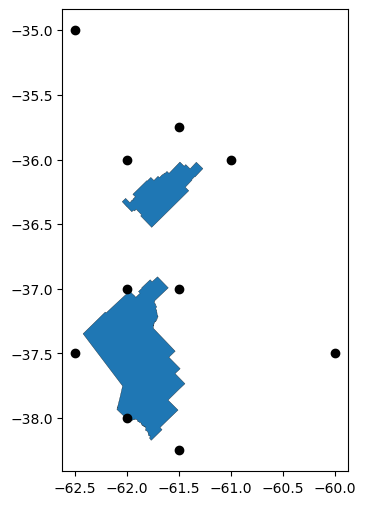

In [188]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gpd.GeoDataFrame(filtered_scm[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

### 3. Bring SCM hindcasts into feature structure

In [189]:
li =[]
for m in relevant_municipalities:
    df = filtered_scm.loc[(filtered_scm["name"] == m)].pivot(index=["model", "year", "init_month", "lat", "lon"], columns=["name", "forecasted_month"], values=["tmean", "rain"]).reset_index()
    df.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in df.columns]
    df.columns = [c.strip("_") for c in df.columns]
    #print(df[["lat", "lon"]].drop_duplicates())
    df = df.set_index(["model", "year", "init_month", "lat", "lon"])
    li.append(df)
#print(len(li))
scm_pivot_test = pd.concat(li, axis=1, join="outer").reset_index().sort_values(by=["model", "year", "init_month", "lat", "lon"]).reset_index(drop=True)

era_raw.columns = ["year", "model", "init_month"] + weather_columns_raw
#weather_columns_raw = [c for c in era_raw.columns if ("rain" in c) or ("tmean" in c)]
scm_pivot_test = scm_pivot_test.loc[: , ["lat", "lon"] + [c for c in scm_pivot_test.columns if c in era_raw.columns]]
scm_pivot_test.sample(3)

,lat,lon,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
3697,-37.5,-60.0,PNU,1995,11,NaN,18.472101,NaN,0.001884,NaN
1397,-37.0,-62.0,ECCC,2001,10,NaN,18.971521,NaN,0.002268,NaN
2062,-36.0,-62.0,GFDL,2008,11,NaN,NaN,NaN,NaN,NaN


### 4. Adjust Bias

In [190]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to monthly values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    adjusted_models = []
    for model in climate_models:
        adjusted_init_months = []
        for month in [9, 10, 11]:
            adjusted_cols = []
            for col in weather_columns_raw:
                adjusted_years = []
                for year in crop_seasons:
                    observations_used_as_reference = observed.loc[(observed["model"] == "ERA") & (observed["year"] != year), col]
                    hindcast_used_as_reference = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month), col]
                    hindcast_to_be_adjusted = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), col].copy()
                    y = predicted.loc[(predicted["model"] == model) & (predicted["init_month"] == month) & (predicted["year"] == year), ["model", "year", "init_month"]].copy()
                    # Perform bias-adjustment 
                    if int(col.split("_")[-1]) >= month:
                        bc_col = BiasCorrection(observations_used_as_reference, hindcast_used_as_reference, hindcast_to_be_adjusted)
                        hindcast_to_be_adjusted = bc_col.correct(method=correction_method)
                    hindcast_to_be_adjusted = pd.concat([y, hindcast_to_be_adjusted], axis=1)
                    adjusted_years.append(hindcast_to_be_adjusted)
                adjusted_years = pd.concat(adjusted_years)
                adjusted_cols.append(adjusted_years)
            adjusted_cols = pd.concat(adjusted_cols, axis=1)
            adjusted_cols = adjusted_cols.loc[:,~adjusted_cols.columns.duplicated()]
            adjusted_init_months.append(adjusted_cols)
        adjusted_init_months = pd.concat(adjusted_init_months)
        adjusted_models.append(adjusted_init_months)
    adjusted_models = pd.concat(adjusted_models).sort_values(by=["model", "year", "init_month"])
    return adjusted_models

In [191]:
scm_bias_adjusted = adjust_bias(era_raw, scm_pivot_test, "basic_quantile")
scm_bias_adjusted.sample(3)

,model,year,init_month,tmean_buenos aires coronel suarez_9,tmean_buenos aires coronel suarez_11,rain_buenos aires coronel suarez_9,rain_buenos aires coronel suarez_11,rain_buenos aires hipolito yrigoyen_9
3088,METFR,2016,10,NaN,16.489083,NaN,0.002863,NaN
1109,DWD,2001,10,NaN,16.290439,NaN,0.003645,NaN
3433,NCEP,1997,9,9.540885,16.277411,0.001398,0.002740,NaN


### 5. Standardize and Basis Expansion

Standardization is done through the LOYO-CV scheme, separately for each model.

In [192]:
def standardize_loyo(data):
    data = data.copy()
    standardized_data = []
    for model in data["model"].unique():
        standardized_data_init_month = []
        for month in data["init_month"].unique():
            standardized_data_current_scm = []
            for year in list(range(1993, 2017)):
                # split
                features_used_for_standardization = data.loc[(data["year"] != year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                features_to_standardize = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), [c for c in data.columns if ("tmean" in c) or ("rain" in c)]].reset_index(drop=True).copy()
                #print(features_used_for_standardization)
                # standardize
                features_standardized = (features_to_standardize - features_used_for_standardization.mean()) / features_used_for_standardization.std()
                # bring it together
                year_model_init_month = data.loc[(data["year"] == year) & (data["model"] == model) & (data["init_month"] == month), ["year", "model", "init_month"]].reset_index(drop=True)
                standardized_df = pd.concat([year_model_init_month, features_standardized], axis=1)
                standardized_data_current_scm.append(standardized_df)
            current_scm_standardized = pd.concat(standardized_data_current_scm, ignore_index=True)
            standardized_data_init_month.append(current_scm_standardized)
        standardized_data_init_month = pd.concat(standardized_data_init_month)
        standardized_data.append(standardized_data_init_month)
    df_standardized = pd.concat(standardized_data)
    return df_standardized

def apply_basis_expansion(data, final_features):
    """
    apply basis expansion to feature-dataframe and return as new dataframe, where original features are replaced with new ones.
    params:
        data: dataframe, with the original features; monthly tmean and monthly rainfall
    returns:
        data_expanded: dataframe, with original features and tmean_squared, rain_squared, and tmean_times_rain features
    """
    df_standardized = standardize_loyo(data)
    df_standardized = df_standardized.sort_values(by=["model", "year", "init_month"]).set_index(["model", "year", "init_month"])

    for col in final_features:
        type_of_expansion = col.split("_")[0]
        location = col.split("_")[1]
        month = col.split("_")[2]
        
        if type_of_expansion == "tmeansquared":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            df_standardized[col] = tmean.mul(tmean)
        if type_of_expansion == "rainsquared":
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain.mul(rain)
        if type_of_expansion == "tmeanrain":
            tmean = df_standardized["tmean_{}_{}".format(location, month)]
            rain = df_standardized["rain_{}_{}".format(location, month)]
            df_standardized[col] = rain * tmean.values
    
    df_standardized = df_standardized[final_features].reset_index()
    
    # standardize expanded features again
    df_standardized = standardize_loyo(df_standardized)
    
    return df_standardized

In [193]:
scm_basis_expansion = apply_basis_expansion(scm_bias_adjusted.reset_index(drop=True), weather_columns_final)
#basis_expansion_weather_columns = [c for c in scm_basis_expansion.columns if ("tmean" in c) or ("rain" in c)]
scm_basis_expansion = scm_basis_expansion.groupby(["model", "year", "init_month"]).mean()[weather_columns_final].reset_index()
scm_basis_expansion.sample(3)

,model,year,init_month,tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
123,CCSM4,2010,9,-0.381838,-0.441042,0.539734,-0.584131
581,HMC,1994,11,NaN,-0.408451,0.207146,NaN
271,CWB,2011,10,NaN,-0.721069,0.155938,NaN


### 6. Fill unskillful months with climatology

#### 6.1 Detect unskillful model-month forecast using out-of-sample R2

In [194]:
def r2_by_feature_init_month_and_scm(init_month, climate_models, era_df, scm_df, features):
    model_to_col_to_r2 = dict.fromkeys(climate_models)
    for model in climate_models:
        forecasted_scm = scm_df.xs(init_month, level=2, drop_level=True).xs(model, level=0, drop_level=True)[features]
        loyo_mean = (era_df[features].sum() - era_df[features]) / (era_df.shape[0] - 1)
        
        ss_total = mse(era_df[features], loyo_mean, multioutput="raw_values")
        ss_model = mse(era_df[features], forecasted_scm, multioutput="raw_values")
        
        current_r2 = 1 - ( ss_model / ss_total )
        model_to_col_to_r2[model] = dict(zip(features, current_r2))

    model_to_col_to_r2 = pd.DataFrame(model_to_col_to_r2)
    model_to_col_to_r2[model_to_col_to_r2 < 0] = np.nan
    return model_to_col_to_r2

r2_9 = r2_by_feature_init_month_and_scm(9, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), weather_columns_final)
r2_10 = r2_by_feature_init_month_and_scm(10, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_9" not in c)])
r2_11 = r2_by_feature_init_month_and_scm(11, climate_models, era_final, scm_basis_expansion.set_index(["model", "year", "init_month"]), [c for c in weather_columns_final if ("_11" in c)])

r2_by_init = r2_9.merge(r2_10.merge(r2_11, left_index=True, right_index=True, suffixes=("", "_11"), how="outer"), left_index=True, right_index=True, suffixes=("_9", "_10"), how="outer")
r2_11

,GFDL,CCSM4,NASA,NCEP,CMCC,DWD,ECMWF,JMA,METFR,UKMO,ECCC,PNU,KMA,CWB,HMC,BOM
tmeansquared_buenos aires coronel suarez_11,0.022189,0.165901,0.161749,0.276233,NaN,NaN,0.165377,NaN,0.340202,NaN,0.379072,NaN,0.091266,0.062073,NaN,0.042415
tmeanrain_buenos aires coronel suarez_11,NaN,NaN,0.439209,0.023631,NaN,NaN,0.402502,NaN,0.122455,NaN,0.179927,NaN,NaN,NaN,NaN,NaN


#### 6.2 Replace with climatology

In [218]:
init_month_to_skill = dict.fromkeys([9, 10, 11])
init_month_to_skill[9] = r2_9.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[10] = r2_10.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()
init_month_to_skill[11] = r2_11.stack().reset_index().groupby("level_0")["level_1"].apply(list).to_dict()

era_climatology = era_final.loc[:, ["year"] + weather_columns_final].set_index("year")
era_climatology = (era_climatology.sum() - era_climatology) / (era_climatology.shape[0] - 1)
era_climatology = era_climatology.reset_index()

# LOYO Climatology
era_columns_no_skill_sep = [c for c in weather_columns_final if c not in list(init_month_to_skill[9].keys())]
era_columns_no_skill_oct = [c for c in weather_columns_final if c not in list(init_month_to_skill[10].keys())]
era_columns_no_skill_nov = [c for c in weather_columns_final if c not in list(init_month_to_skill[11].keys())]

scm_filled_climatology = scm_basis_expansion.copy()
#scm_basis_expansion_climatology.xs(9, axis=0, level=1, drop_level=True).reset_index().set_index("year")[era_columns_no_skill_sep] = era_climatology[era_columns_no_skill_sep]
sep = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_sep]].merge(era_climatology[["year"] + era_columns_no_skill_sep], on="year")
oct = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_oct]].merge(era_climatology[["year"] + era_columns_no_skill_oct], on="year")
nov = scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in scm_filled_climatology.columns if c not in era_columns_no_skill_nov]].merge(era_climatology[["year"] + era_columns_no_skill_nov], on="year")

scm_filled_climatology = pd.concat([sep, oct, nov], ignore_index=True, axis=0)

scm_filled_climatology.loc[(scm_filled_climatology["model"] == "NASA") & (scm_filled_climatology["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
396,1993,0.417412
412,1994,0.294470
428,1995,0.336808
444,1996,-0.415665
460,1997,0.108712


In [219]:
scm_basis_expansion.loc[(scm_basis_expansion["model"] == "NASA") & (scm_basis_expansion["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
865,1993,0.417412
868,1994,0.294470
871,1995,0.336808
874,1996,-0.415665
877,1997,0.108712


In [220]:
for im in [9, 10, 11]:
    for col in list(init_month_to_skill[im].keys()):
        scm_with_no_skill = [c for c in climate_models if c not in init_month_to_skill[im][col]]
        for model in scm_with_no_skill:
            print("{}, {}, {}".format(im, col, model))
            filter_model = scm_filled_climatology["model"] == model
            filter_init_month = scm_filled_climatology["init_month"] == im
            new_values = (era_final[col].sum() - era_final[col]) / (era_final[col].shape[0] - 1)
            new_values = new_values.values
            scm_filled_climatology.loc[(filter_model) & (filter_init_month), col] = new_values

9, tmeanrain_buenos aires coronel suarez_11, GFDL
9, tmeanrain_buenos aires coronel suarez_11, CMCC
9, tmeanrain_buenos aires coronel suarez_11, DWD
9, tmeanrain_buenos aires coronel suarez_11, JMA
9, tmeanrain_buenos aires coronel suarez_11, METFR
9, tmeanrain_buenos aires coronel suarez_11, UKMO
9, tmeanrain_buenos aires coronel suarez_11, ECCC
9, tmeanrain_buenos aires coronel suarez_11, PNU
9, tmeanrain_buenos aires coronel suarez_11, KMA
9, tmeanrain_buenos aires coronel suarez_11, CWB
9, tmeanrain_buenos aires coronel suarez_11, HMC
9, tmeanrain_buenos aires coronel suarez_11, BOM
9, tmeanrain_buenos aires coronel suarez_9, GFDL
9, tmeanrain_buenos aires coronel suarez_9, CCSM4
9, tmeanrain_buenos aires coronel suarez_9, NASA
9, tmeanrain_buenos aires coronel suarez_9, CMCC
9, tmeanrain_buenos aires coronel suarez_9, DWD
9, tmeanrain_buenos aires coronel suarez_9, ECMWF
9, tmeanrain_buenos aires coronel suarez_9, JMA
9, tmeanrain_buenos aires coronel suarez_9, METFR
9, tmeanrain_

In [221]:
scm_filled_climatology.loc[(scm_filled_climatology["model"] == "NASA") & (scm_filled_climatology["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
396,1993,0.023029
412,1994,0.009838
428,1995,-0.052787
444,1996,-0.054087
460,1997,-0.077683


In [222]:
scm_basis_expansion.loc[(scm_basis_expansion["model"] == "NASA") & (scm_basis_expansion["init_month"] == 10), ['year', 'tmeanrain_buenos aires coronel suarez_11']].head()

,year,tmeanrain_buenos aires coronel suarez_11
865,1993,0.417412
868,1994,0.294470
871,1995,0.336808
874,1996,-0.415665
877,1997,0.108712


In [223]:
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 9, [c for c in weather_columns_final if int(c.split("_")[-1]) < 9]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 10, [c for c in weather_columns_final if int(c.split("_")[-1]) < 10]] = np.nan
scm_filled_climatology.loc[scm_filled_climatology["init_month"] == 11, [c for c in weather_columns_final if int(c.split("_")[-1]) < 11]] = np.nan

### 5. Fill past months with ERA data

In [195]:
scm_yield = scm_basis_expansion.merge(era_final[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
scm_yield = scm_yield[era_final.columns].set_index("year").combine_first(era_final.set_index("year")).reset_index()
# Concat ERA with init_month = 12  
scm_era = pd.concat([scm_yield, era_final], ignore_index=True)
scm_era = scm_era.drop_duplicates().reset_index(drop=True)
scm_era = scm_era.loc[scm_era["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)
# Preview
scm_era.sample(5)

,year,model,init_month,yield [kg/ha],yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,tmeansquared_buenos aires coronel suarez_11,tmeanrain_buenos aires coronel suarez_11,rainsquared_buenos aires hipolito yrigoyen_9
454,2000,ECMWF,10,2551.682571,0.045319,-1.246346,-0.037560,0.329891,-0.529259
1136,2003,UKMO,11,2687.698352,0.086721,-0.191102,2.337749,-1.817368,0.057128
1156,2010,UKMO,10,3933.646839,0.395993,0.563449,0.060458,-0.735446,7.542780
705,2004,JMA,9,2768.367390,0.093354,0.103254,-0.459290,-0.225567,-0.371031
229,1997,CWB,10,2623.252920,0.175913,0.760139,1.683235,-0.002042,-0.440915


### 7. Analyse Bias

In [196]:
# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
scm_models = [c for c in scm_era.model.unique().tolist() if c != "ERA"]
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

In [197]:
scm_bias = scm_era.loc[scm_era["model"].isin(scm_models)]
era_bias = scm_era.loc[scm_era["model"] == "ERA"].set_index("year")[weather_columns]

all_bias = []
for model in scm_models:
    for month in init_months:
        current_scm = scm_bias.loc[(scm_bias["model"] == model) & (scm_bias["init_month"] == month)].set_index("year")
        current_scm_bias = abs(current_scm[weather_columns] - era_bias)
        current_scm_info = current_scm[['model', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
        current_scm_bias.loc[:, [c for c in weather_columns if int(c.split("_")[-1]) < month]] = np.nan
        current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1).groupby(['model', 'init_month'])[weather_columns].mean().reset_index(drop=False)
        #current_scm = pd.concat([current_scm_info, current_scm_bias], axis=1)[['model', 'init_month']+weather_columns]
        all_bias.append(current_scm)
all_bias = pd.concat(all_bias)

In [198]:
all_bias = all_bias.set_index(["model", "init_month"]).stack().reset_index()
all_bias.columns = ["model", "init_month", "feature", "bias"]

<Axes: ylabel='model'>

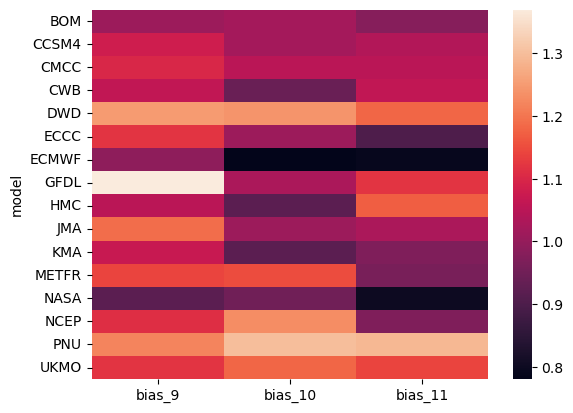

In [199]:
bias_heatmap = (all_bias.loc[(all_bias["init_month"] == 9)].groupby("model")["bias"].mean().reset_index()
                .merge(all_bias.loc[(all_bias["init_month"] == 10)].groupby("model")["bias"].mean().reset_index()
                        .merge(all_bias.loc[(all_bias["init_month"] == 11)].groupby("model")["bias"].mean().reset_index(), on="model", suffixes=("", "_11")), on="model", suffixes=("_9", "_10"))
                .round(2))
sns.heatmap(bias_heatmap.set_index("model"))

<Axes: xlabel='bias', ylabel='feature'>

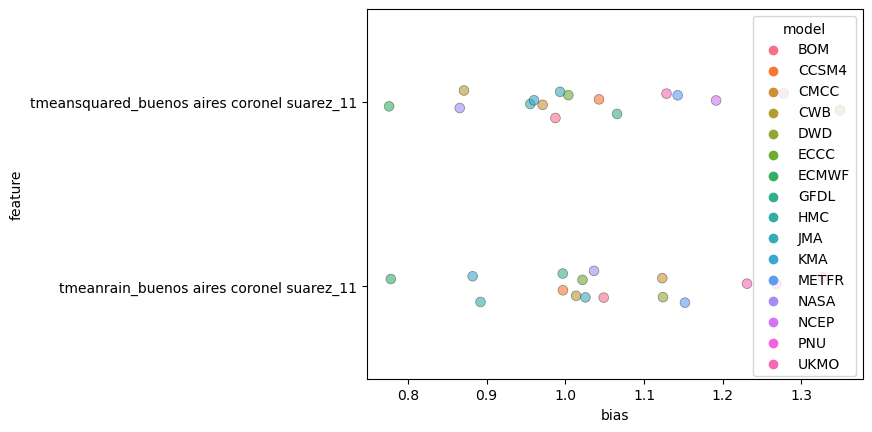

In [200]:
sns.stripplot(data=all_bias.loc[(all_bias["init_month"] == 10)], x="bias", y="feature", orient="h", s=7, linewidth=0.5, alpha=.6, hue="model", jitter=True, size=(20,20))

## EXPORT

In [201]:
scm_era.to_csv("files/ERA/features/scm_era_features_filtered_case41.csv", index=False)